In [1]:
import os
os.chdir(r"C:\Users\vitor\Google Drive\programas\meus\python\Pasta Padrao\kaggle titanic")

In [2]:
# import dill
# dill.load_session('Base_Titanic_env.db')

Based on:

https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy#A-Data-Science-Framework

https://www.kaggle.com/startupsci/titanic-data-science-solutions

https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling


# Intro
* Binary classification

Our objective is to predict if a person would survive the titanic aciddent or not, based on their data.

On this notebook I will follow this specific data analyses steps:


#### some pre-assumptions provided by data provider:
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. *From this info we may expect a 0,68% death rate.*

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. *From this info we may expect that some criteria was used to choose who may enter de lifeboats.*

Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class. *From this info we have a clue of what features are more significant.*

- [ ] ToDo erase: set nice colors!


# Enviroment Setup

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
#load Main Libraries
import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

#misc libraries
from collections import Counter
import random
import time


# #ignore warnings
# import warnings
# warnings.filterwarnings('ignore')
# print('-'*25)


pandas version: 0.24.2
matplotlib version: 3.0.3
NumPy version: 1.16.2
scikit-learn version: 0.20.3


In [4]:
# MODELLING LIBRARIES
# We will use the popular scikit-learn library to develop our machine learning algorithms. 
# In sklearn, algorithms are called Estimators and implemented in their own classes. 
# For data visualization, we will use the matplotlib and seaborn library.
# Below are common classes to load.


#Common Model Algorithms
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

#Common Model Helpers
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder,KBinsDiscretizer
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics


#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.style as style
import seaborn as sns
from pandas.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
# sns.set(palette='muted')
sns.set(style='whitegrid', context='notebook', palette='bright')
# sns.set(context='notebook', palette='bright')
# style.use('ggplot')
# sns.set(style='white', context='notebook', palette='deep')

pylab.rcParams['figure.figsize'] = 12,8


In [5]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Join train and test datasets in order to obtain the same number of features during categorical conversion
dataset =  pd.concat(objs=[train_data, test_data], axis=0, sort=False).reset_index(drop=True)

In [6]:
# # Drop outliers
# train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## Quick look and Check for null and missing values

In [7]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

missing_by_col = train_data.isna().sum()
print('train missing data')
print (missing_by_col[missing_by_col>0])

print("")
missing_by_row = train_data.isna().sum(axis=1).count()
print (missing_by_row,' total rows with missing data')
print('-'*30)
missing_by_col = test_data.isna().sum()
print('test missing data')
print (missing_by_col[missing_by_col>0])

print("")
missing_by_row = test_data.isna().sum(axis=1).count()
print (missing_by_row,' total rows with missing data')

train missing data
Age         177
Cabin       687
Embarked      2
dtype: int64

891  total rows with missing data
------------------------------
test missing data
Age       86
Fare       1
Cabin    327
dtype: int64

418  total rows with missing data


**From our structure, we have:**

Which features are numerical? 
* Continous: Age, Fare. 
* Discrete: SibSp, Parch.

Which features are categorical?
* Categorical: Survived, Sex, and Embarked
* Ordinal: Pclass.

Which features are mixed data types?
* Ticket is a mix of numeric and alphanumeric data types. 
* Cabin is alphanumeric.

Which features may contain errors or typos?
* Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

Which features contain blank, null or empty values?
* Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.
* Cabin > Age > Fare are incomplete in case of test dataset.


In [10]:
# IDcolumns is data with no meaning, just ordered data
IDtrain = train_data['PassengerId']
IDtest = test_data['PassengerId']
train_data.drop(columns=['PassengerId'],inplace=True)
test_data.drop(columns=['PassengerId'],inplace=True)
dataset.drop(columns=['PassengerId'],inplace=True)

## Outlier Detection

In [11]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_data,2,["Age","SibSp","Parch","Fare"])

train_data.loc[Outliers_to_drop] # Show the outliers rows


C:\Users\vitor\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


'Here we choosed to set any row with double outliers as a todrop outrlier.
Since, most outliers would be big families, they will not be dropped, since, there be value in underding how big families may be correlated to survival.

### Quick Describe

In [12]:
# What is the distribution of numerical feature values across the samples?

print(train_data.describe())
print('-'*30)
print(test_data.describe())

         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200
------------------------------
           Pclass         Age       SibSp       Parch        Fare
count  418.000000  332.000000  418.000000  418.000000  417.000000
mean     2.265550   30.272590    0.447368    0.392344   35.627188
std      0.841838   14.181209    0.896760    0.981429   55.907576
min

* Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
* Survived is a categorical feature with 0 or 1 values.
* Around 38% samples survived representative of the actual survival rate at 32%.
* Most passengers (> 75%) did not travel with parents or children.
* Nearly 30% of the passengers had siblings and/or spouse aboard.
* Fares varied significantly with few passengers (<1%) paying as high as $512.
* Few elderly passengers (<1%) within age range 65-80.


- [x] Todo: Check Fare Distribution
- [ ] Todo: Check Age Distribution


In [13]:
# What is the distribution of Categorical feature values across the samples?

print(train_data.describe(include=['O']))
print('-'*30)
print(test_data.describe(include=['O']))

                                Name   Sex  Ticket    Cabin Embarked
count                            891   891     891      204      889
unique                           891     2     681      147        3
top     Crosby, Capt. Edward Gifford  male  347082  B96 B98        S
freq                               1   577       7        4      644
------------------------------
                                                Name   Sex    Ticket  \
count                                            418   418       418   
unique                                           418     2       363   
top     Hirvonen, Mrs. Alexander (Helga E Lindqvist)  male  PC 17608   
freq                                               1   266         5   

                  Cabin Embarked  
count                91      418  
unique               76        3  
top     B57 B59 B63 B66        S  
freq                  3      270  


* Names are unique across the dataset (count=unique=891)
* Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
* Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
* Embarked takes three possible values. S port used by most passengers (top=S)
* Ticket feature has high ratio (22%) of duplicate values (unique=681).

# Basic Features Analysis 
- Numerical Values
- Categorical Values
- Features Correlation

## Numerical Values

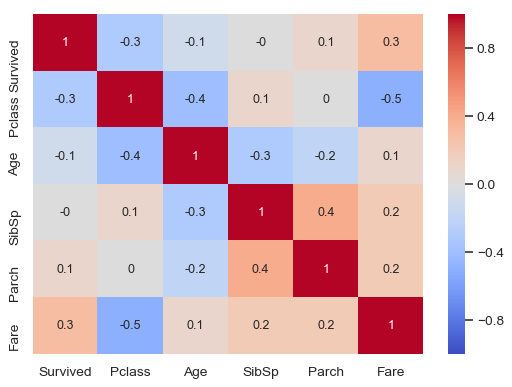

In [14]:
### On numerical values
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
plt.figure(figsize=(7, 5), dpi= 90)
g = sns.heatmap(train_data.corr().round(1),
                annot=True, center=0, vmin=-1, vmax=1,
                cmap = "coolwarm")

Only Fare feature seems to have a significative correlation with the survival probability.

It doesn't mean that the other features are not usefull. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features.
- [ ] Todo: Explore subpopulations

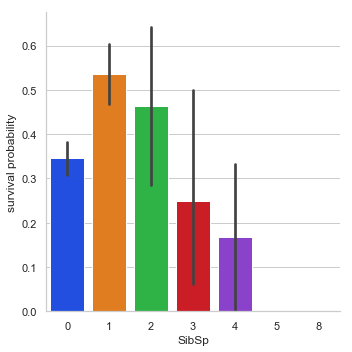

In [15]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="SibSp",y="Survived",data=train_data,
                kind="bar")
g = g.set_ylabels("survival probability")

It seems that passengers having a lot of siblings/spouses have less chance to survive

Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive

This observation is quite interesting, we can consider a new feature describing these categories (See feature engineering)

*Vertical line represents bootstrap results for confidence*

- [ ] Todo: Feature engineer no fmaily and small family

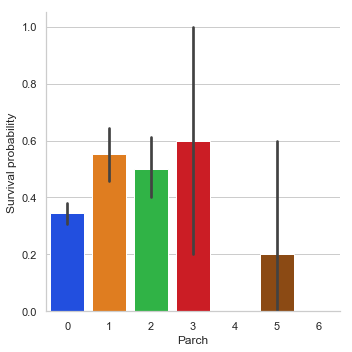

In [16]:
g = sns.catplot(x='Parch', y='Survived',data=train_data,
               kind='bar')
g = g.set_ylabels('Survival probability')

Small families (Parch 1,2) have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).

Be carefull there is an important standard deviation in the survival of passengers with 3 parents/children

- [ ] Todo: Feature engineer no fmaily and small family
- [ ] Todo: Engineer and test full family feature (Parch+SisSp)

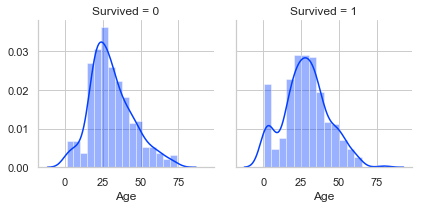

In [17]:
# Lets Explore Age vs Survived
g = sns.FacetGrid(train_data,col = 'Survived') # mount FacetGrid
g = g.map(sns.distplot,'Age') #Fill Grid

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

It seems that very young passengers have more chance to survive.

'Notice that the representations seems a little deslocated toward the left side in not survived plot. May represent higher chances of death for young adults.

C:\Users\vitor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\vitor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


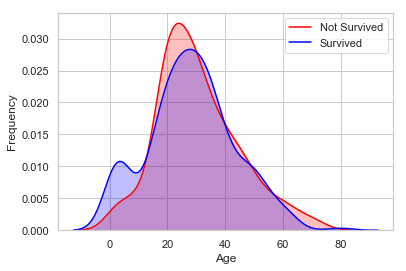

In [18]:
# More on Age distribution. Let's take a closer look.
g = sns.kdeplot(train_data['Age'][(train_data['Survived']==0)],
               color='Red', shade=True)
g = sns.kdeplot(train_data['Age'][(train_data['Survived']==1)],
               color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

#warnings are for NaN values.

In [19]:
# temp_train_data = train_data.copy()
# temp_train_data['AgeBin'] = pd.cut(temp_train_data['Age'].astype(int), 10)
# # survive_table(temp_train_data,'AgeBin',sort=False)

# #AgeBin  vs Survived
# plt.figure(figsize=(15, 5), dpi= 90)
# g = sns.barplot(x='AgeBin',y='Survived', data = temp_train_data)
# g = g.set_xticklabels(g.get_xticklabels(), rotation=90)


- [ ] ToDo: Add Binner to Age Pipeline

When we superimpose the two densities , we cleary see a peak correponsing (between 0 and 5) to babies and very young childrens.

'Also the 20-30 seems to have higher no survival rate

- [ ] Todo: Engineer IsChildren feature
- [ ] Todo: Engineer YoungAdult feature
- [ ] Todo: Check table data for more Realistic bins: (0-5 or 0-10), (20-30 or 15-35)

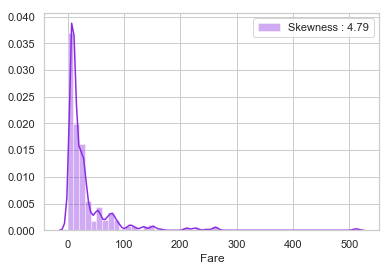

In [20]:
# Explore Fare distribution 
g = sns.distplot(train_data["Fare"],
                 color="m", label="Skewness : %.2f"%(train_data["Fare"].skew()))
g = g.legend(loc="best")

Our Fare data is higly skewed. In this case we may apply a transformation to reduce it skweness. This way, we may avoid overweighting extreme values.

"If skewness value lies above +1 or below -1, data is highly skewed. If it lies between +0.5 to -0.5, it is moderately skewed. If the value is 0, then the data is symmetric."

'See https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55 for more in skeweness and transformations.

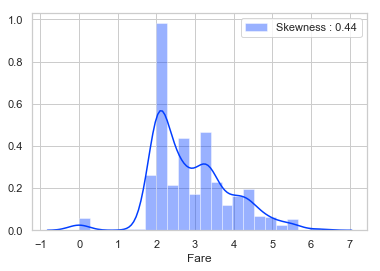

In [21]:
# Apply log to Fare to reduce skewness distribution
modified_train_data = train_data.copy()
modified_train_data["Fare"] = train_data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
g = sns.distplot(modified_train_data["Fare"],
                 color="b",
                 label="Skewness : %.2f"%(modified_train_data["Fare"].skew()))
g = g.legend(loc="best")

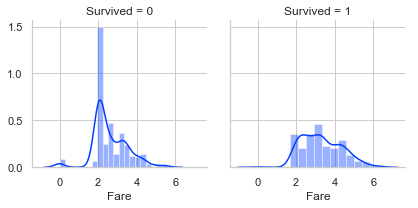

In [22]:
# Lets Explore Log_Fare vs Survived
g = sns.FacetGrid(modified_train_data,col = 'Survived') # mount FacetGrid
g = g.map(sns.distplot,'Fare') #Fill Grid

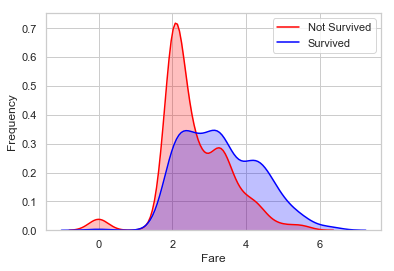

In [23]:
# More on Log_fare distribution. Let's take a closer look.
g = sns.kdeplot(modified_train_data['Fare'][(modified_train_data['Survived']==0)],
               color='Red', shade=True)
g = sns.kdeplot(modified_train_data['Fare'][(modified_train_data['Survived']==1)],
               color='Blue', shade=True)
g.set_xlabel('Fare')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

#warnings are for NaN values.

Indeed there seem to be significant diference between survived and not survived Log_fare distribution
- [ ] Todo: Add Log Transformation to fare pipeline 

## Categorical Values

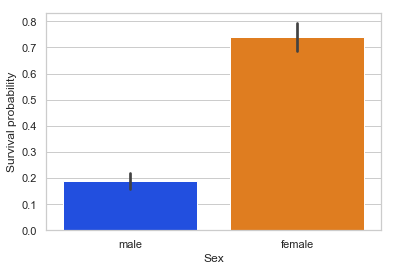

In [24]:
#Sex  vs Survived
g = sns.barplot(x='Sex',y='Survived', data = train_data)
g = g.set_ylabel('Survival probability')

Clearly, female have greatest chance of survival.
- [ ] Todo: Add Sex as a categorical variable
- [ ] Todo: Convert sex to binary

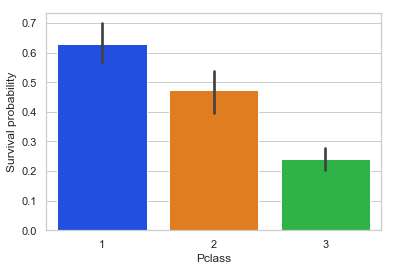

In [25]:
# PClass vs Survived
g = sns.barplot(x='Pclass',y='Survived', data = train_data)
g = g.set_ylabel('Survival probability')

There is indeed a high negative correlation between surviving and the Pclass.
The better the social economic status, the higher survival chances.

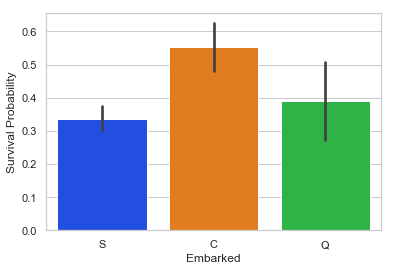

In [26]:
# Embarked vs Survived
g = sns.barplot(x='Embarked', y='Survived', data = train_data)
g = g.set_ylabel('Survival Probability')

It seems that people from C (Cherbourg) have greater chance of survival. Since it's dificult to justify why a city of embark have high correlation with survival rate, we should investigate if there is high correlation with other features that make this data a depedent+noise data. This would overfit our model.

- [ ] Todo: Verify correlation of embarked and other variables.

## Features relations
Let's search for dependent features.
Let's focus in those whose results are rpoven to be important to our survival rate.

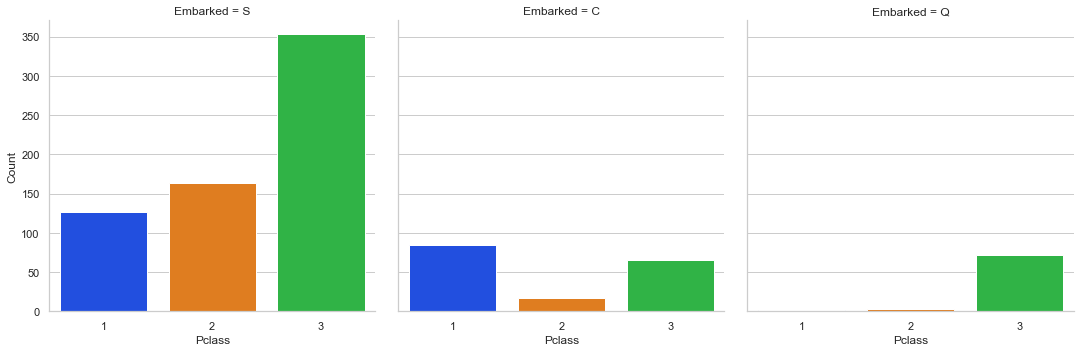

In [27]:
# Explore Pclass vs Embarked 

g = sns.catplot("Pclass", col="Embarked",  data=train_data,
                   kind="count")
g = g.set_ylabels("Count")

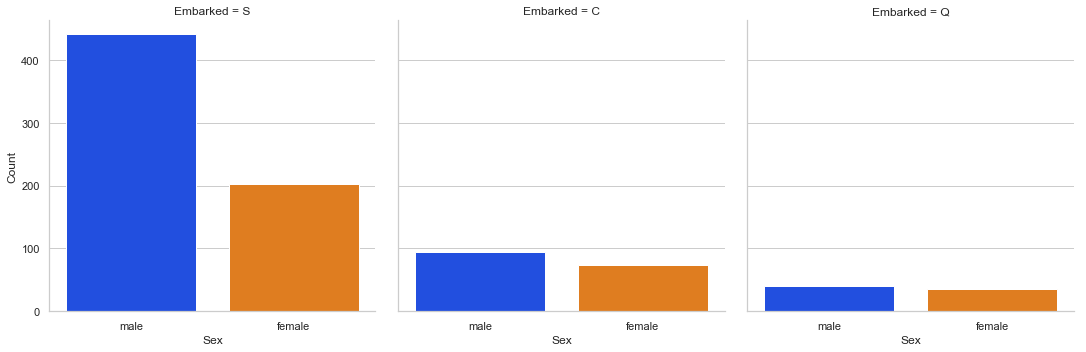

In [28]:
# Explore Sex vs Embarked 

g = sns.catplot("Sex", col="Embarked",  data=train_data,
                   kind="count")
g = g.set_ylabels("Count")

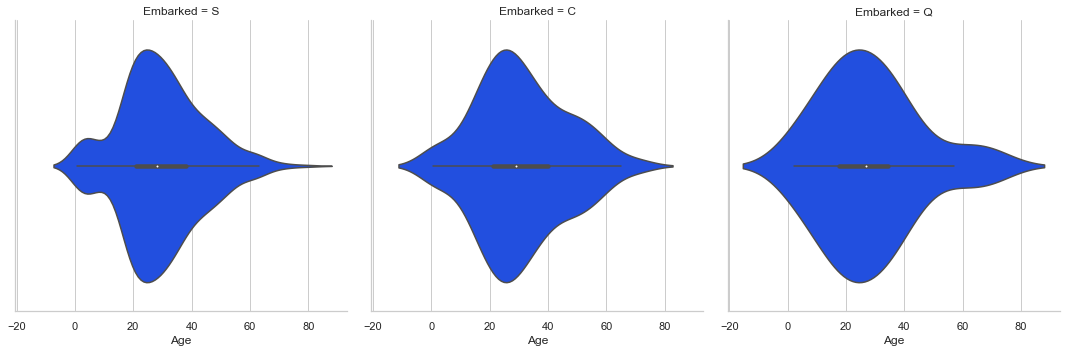

In [29]:
# Explore Age vs Embarked 

g = sns.catplot("Age", col="Embarked",  data=train_data,
                   kind="violin")

From The embarked relation to other significant features, we found out that:
- There is more Pclass1 concentration on the Cherbourg embark indicating more survival rate, some Dependence here
- Female concentration is lesser in Southtown embark, indicating lesser survival rate. Some depence here.
- The children peek in Southtown, is a little contradictory to its lesser survival rate. Some indepence here.

It's higly possible that Embark survival rates are results of the other 3 main variable, specialy if PClass and Female have higer weights than children. 

- [ ] Todo: Verify model results with and without Embarked. If the results are similar or lesser, exclude Embarked to avoid overfitting. (add Embarked by onehot encoding will add at least 2 more variables to the model)  

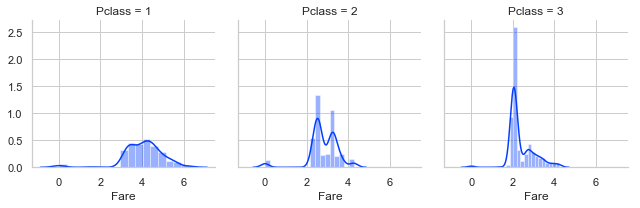

In [30]:
# Lets Explore Pclass vs Fare
g = sns.FacetGrid(modified_train_data,col = 'Pclass') # mount FacetGrid
g = g.map(sns.distplot,'Fare') #Fill Grid

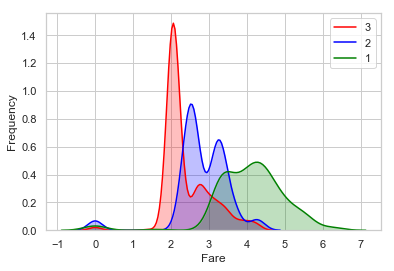

In [31]:
g = sns.kdeplot(modified_train_data['Fare'][(modified_train_data['Pclass']==3)],
               color='Red', shade=True)
g = sns.kdeplot(modified_train_data['Fare'][(modified_train_data['Pclass']==2)],
               color='Blue', shade=True)
g = sns.kdeplot(modified_train_data['Fare'][(modified_train_data['Pclass']==1)],
               color='Green', shade=True)
g.set_xlabel('Fare')
g.set_ylabel('Frequency')
g = g.legend(['3','2','1'])

Here we can find indeed that they are somewhat dependent, as expected. But still there is a high overlap btween series. So the dependence is not direct. There is people that almost didn't paid in all Pclasses. There is all of them around the logfare 3,5.
- [ ] Todo: Verify model with and without Fare, it may influence the results. If not, there's a razoable chance of dependence.

# Drop, Convert, Complete Missing Values


First, lets convert fare Data as settled before.

In [32]:
# Tranform sex into binary.
for df in [train_data,test_data,dataset]:
    df["Female"] = df["Sex"].map(lambda i: 1 if i == 'female' else 0)
    df.drop(columns=["Sex"], inplace=True)

In [33]:
# Convert the Fare data to log_Fare and normalize it from 0 to 1.
for df in [train_data,test_data,dataset]:
    df["Fare"] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)


In [34]:
min_max_fare_scaler = MinMaxScaler()
min_max_fare_scaler.fit(train_data[["Fare"]])

for df in [train_data,test_data,dataset]:
    df["Fare"] = min_max_fare_scaler.transform(df[['Fare']])

In order to fill missing values, a series of methods could be used. We could use simple Median/Mean methods or we could build predictors for this missing features based on other features.

It's important do describe that any method used will not furfill the adding information that a new data would actualy do. But the use of a filling could reduce the information losed from the absence of data. All methods will be based on data distribution assumptions.

In [35]:
missing_by_col = dataset.isna().sum()
print('Total missing data')
print (missing_by_col[missing_by_col>0])

Total missing data
Survived     418
Age          263
Cabin       1014
Embarked       2
dtype: int64


Missing survived data is just Teste data. No correction needed.

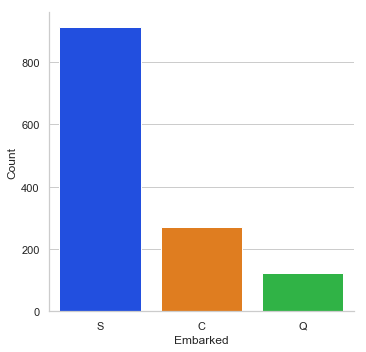

In [36]:
# Filling embarked data
# in all the data there is only 2 rows missing this data.
# We could go for a simple most common value filling
g = sns.catplot("Embarked",  data=dataset,
                   kind="count")
g = g.set_ylabels("Count")

In [37]:
# fill with most common train value
most_common = train_data['Embarked'].mode().iloc[0]
for df in [train_data,test_data,dataset]:
    df['Embarked'] = df['Embarked'].fillna(most_common)

In [38]:
# Filling Fare data
# We already found out the high correlation between log_Fare and Pclass.
# We could fill log_Fare data with the median of it's own Pclass
Pclass2Fare = train_data.groupby('Pclass').median()['Fare'].to_dict() #Create Dict for mapping
for df in [train_data,test_data,dataset]:
    df['Fare']= df['Fare'].fillna(test_data['Pclass'].map(Pclass2Fare))


Age will request a better filling technique, since there is a lot of them, and since it's a important feature.
In order to fill it we should use higly correlated features as seen on the correlation heatmap.

Futhermore, we should test it's correlation to categorical features.

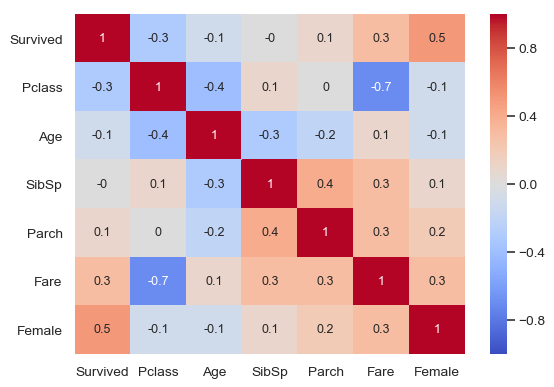

In [39]:
plt.figure(figsize=(7, 5), dpi= 90)
g = sns.heatmap(train_data.corr().round(1),
                annot=True, center=0, vmin=-1, vmax=1,
                cmap = "coolwarm")

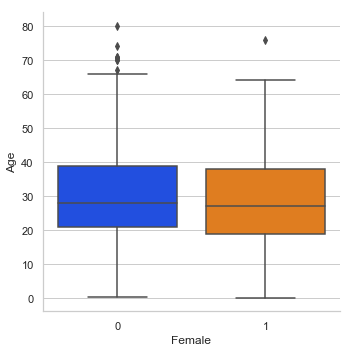

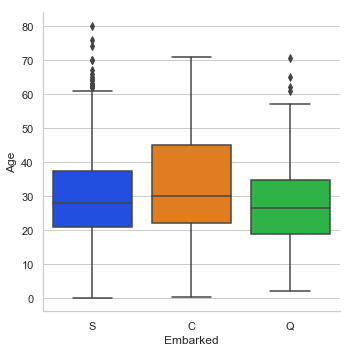

In [40]:
g = sns.catplot(y="Age",x="Female",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Embarked",data=dataset,kind="box")

In [41]:
#The only Feature that seems to be Age correlated.
High_Age_correlated = ['Pclass', 'SibSp', 'Parch']

To avoid using ML methods at this part we may input missing age comparing similar objects.
Futhermore, we may wish to add a random deviation effect to our data, in order to avoid some overfitting generate by our age guessing.

Our method will consist of calculating the median of all complete match in all 3 correlated features.  If not able to find any, we will search for the most 2 correlated features, and then if need for the most correlated feature.

We are going to plot age vs survived distribution in order to verify if it remained as the original data.

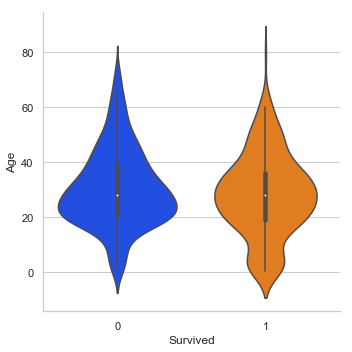

In [42]:
g = sns.catplot(x="Survived", y = "Age",data = train_data, kind="violin")

In [43]:
for df in [train_data,test_data,dataset]:
    index_NaN_age = list(df["Age"][df["Age"].isnull()].index)
    for i in index_NaN_age:
        age_pred = train_data["Age"][(
            (train_data['Pclass'] == df.loc[i]["Pclass"])
            & (train_data['SibSp'] == df.loc[i]["SibSp"])
            & (train_data['Parch'] == df.loc[i]["Parch"])
        )].median()
        if np.isnan(age_pred):
            age_pred = train_data["Age"][(
                (train_data['Pclass'] == df.loc[i]["Pclass"])
                & (train_data['SibSp'] == df.loc[i]["SibSp"])
            )].median()            
            if np.isnan(age_pred):
                age_pred = train_data["Age"][(
                    (train_data['Pclass'] == df.loc[i]["Pclass"])
                )].median() 
            
        df['Age'].loc[i] = age_pred

C:\Users\vitor\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


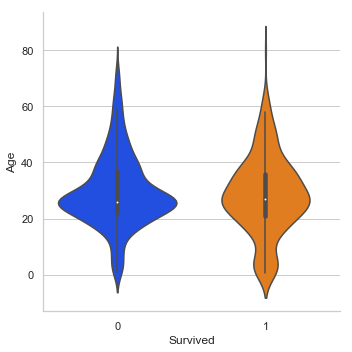

In [44]:
g = sns.catplot(x="Survived", y = "Age",data = train_data, kind="violin")

The plot distribution remained simillar, but the increase in data volume made the curves less rounded.

In [45]:
def survive_table (data,key, sort = 'Survived'):
    # display complete personalized table
    display_df = data[[key,'Survived']].groupby([key]).agg(['mean', 'count'])
    display_df = display_df['Survived']
    display_df.rename(columns={'mean':'Survived'}, inplace=True)
    display_df['Survived'] = display_df['Survived'].round(2)
    rows_count = display_df['count'].sum()
    display_df['%of data'] = (display_df['count']/rows_count).round(2)
    
    if sort == 'Survived':
        with pd.option_context('display.max_rows',None):
            display(display_df.sort_values(by='Survived', ascending=False))
    elif sort == 'count':
        with pd.option_context('display.max_rows',None):
            display(display_df.sort_values(by='count', ascending=False))
    elif sort == False:
        with pd.option_context('display.max_rows',None):
            display(display_df)

In [46]:
train_maxage = train_data['Age'].max()
train_minage = train_data['Age'].min()
 
age_bins_scaler = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
age_bins_scaler.fit(train_data[['Age']])


for df in [train_data,test_data,dataset]:
    df['TempAge'] = df['Age'].map(lambda x: 
                              train_minage if x<train_minage 
                              else(train_maxage if x>train_maxage else x))
    df["AgeBin"] = age_bins_scaler.transform(df[['Age']])
    df.drop(columns=["TempAge"], inplace=True)
    
survive_table(train_data,'AgeBin',sort = 'Survived')
dataset = pd.get_dummies(dataset, columns = ["AgeBin"], prefix="AgeBin",prefix_sep='_',drop_first=False) #!!!

train_data = dataset[:len(train_data.index)]
test_data = dataset[-len(test_data.index):]

,Survived,count,%of data
AgeBin,,,
0.0,0.62,58,0.07
9.0,0.50,2,0.00
6.0,0.47,45,0.05
4.0,0.45,148,0.17
1.0,0.40,48,0.05
7.0,0.38,24,0.03
2.0,0.37,183,0.21
5.0,0.34,70,0.08
3.0,0.33,304,0.34


In [47]:
missing_by_col = dataset.isna().sum()
print('Total missing data')
print (missing_by_col[missing_by_col>0])

Total missing data
Survived     418
Cabin       1014
dtype: int64


# Feature Engineering cycle
From our ToDo's list we have the following features to engineer
- [ ] Convert the Embarked data (OHE)
- [ ] Normalize data

- [ ] Title
- [ ] is child? (age bins)
- [ ] Full Family size
- [ ] Have vs don't have cabin data
- [ ] Ticket Prefixes
- [ ] A Family member survived?

Most of our transformations should be done taken into account that test data may have data that is diferent from trian data.
The best scenario is to apply all transformations to the full dataset and then re-slice it into train/test.
The best method doesn't should be resilient to worst scenarios where test data may not be similar in it's imperctions to trian data and we may not see test data before training is done. To archieve a better method we may generate a resilient map with the train data and also generate a pipeline to treat any posterior data and also avoid any data leakage that may incur in overfitting.

## Feature: OHE Embarked

Simple Onehot Encode, no analisys needed, no new info.

In [48]:
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Emb",prefix_sep='_',)
dataset = dataset.drop(columns=['Emb_S'])

## Feature: Create  HaveCabin
binary

In [49]:
dataset['HaveCabin']=pd.Series([1 if not pd.isnull(i) else 0 for i in dataset['Cabin']])
dataset = dataset.drop(columns=['Cabin'])

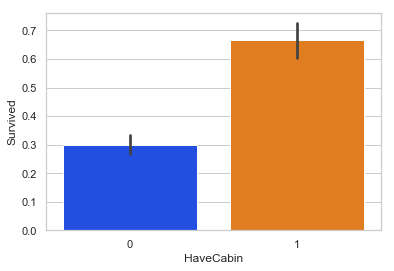

In [50]:
g = sns.barplot(x='HaveCabin',y='Survived', data = dataset)

Indeed, for some reason to have a cabin will give better survival chances. Maybe only the data of important people was captured or even only important people had a cabin previously aloccated. Is this a coincidence or is it related to something like Pclass?

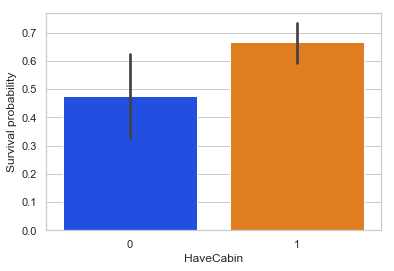

In [51]:
# Title vs Survived
g = sns.barplot(x='HaveCabin',y='Survived', data = dataset[dataset['Pclass']==1])
g = g.set_ylabel('Survival probability')

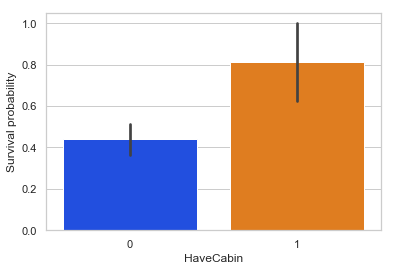

In [52]:
g = sns.barplot(x='HaveCabin',y='Survived', data = dataset[dataset['Pclass']==2])
g = g.set_ylabel('Survival probability')

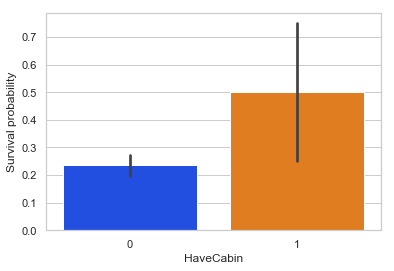

In [53]:
g = sns.barplot(x='HaveCabin',y='Survived', data = dataset[dataset['Pclass']==3])
g = g.set_ylabel('Survival probability')

It seems to be a variable independent of Pclass. 
Let's keep it.

## Feature: Title
The title feature is based on the ideia that title might represent something that is not contained in the rest of the data. 

In [54]:
# familyName and Title quick split
fixed_titles= train_data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
# Since some titles have litle representativeness, each title with 
# occurency under 5 will be renamed as "Rare" the list is train data permanent.
title_count=fixed_titles.value_counts()>5
title_list=title_count[title_count].index

for df in [train_data,test_data,dataset]:
    df['Title']= df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    df['Title'] = [i if (i in title_list) else 'Rare' for i in df['Title']]


### Feature 01: Title - Analisys

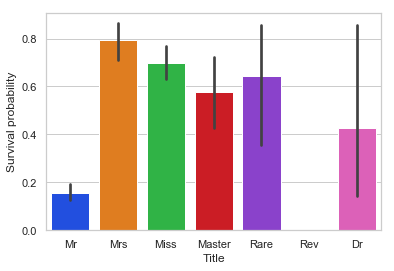

In [55]:
# Title vs Survived
g = sns.barplot(x='Title',y='Survived', data = train_data)
g = g.set_ylabel('Survival probability')

Rare's have high variability as expected from a mix of titles. Dr have a frequency too high to be adopted as something diferent from Rare. 

We should question if this is not simply a "male/female" representation.

Does the Reverends stayed on titanic for religious reasons? It may be so. 

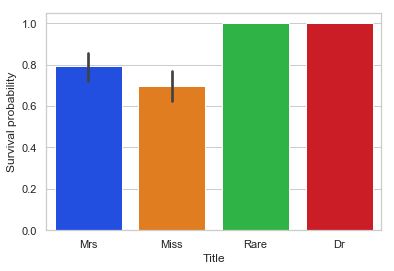

In [56]:
g = sns.barplot(x='Title',y='Survived', data = train_data[train_data['Female'] == 1])
g = g.set_ylabel('Survival probability')

It seems that having a title other than Miss or Mrs is indeed better for survival chances. Other titles shows no uncearntanty (investigate).

In order too give a unbiased opinion, we need to check representativity. Theese results may just be a metter of small representativity

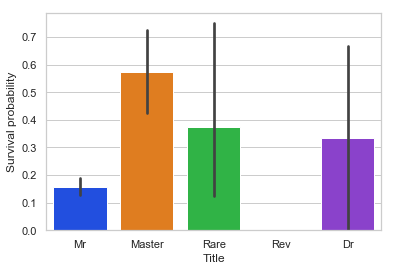

In [57]:
g = sns.barplot(x='Title',y='Survived', data = train_data[train_data['Female'] == 0])
g = g.set_ylabel('Survival probability')

It seems that having a title of Master is indeed better for survival chances. Other titles show too high uncearntanty. Reverends shows no uncearntanty (investigate).

In [58]:
print('female data')
survive_table(train_data[train_data['Female']==1],'Title')
print('-'*30)
print('male data')
survive_table(train_data[train_data['Female']==0],'Title')


female data


,Survived,count,%of data
Title,,,
Dr,1.00,1,0.00
Rare,1.00,6,0.02
Mrs,0.79,125,0.40
Miss,0.70,182,0.58


------------------------------
male data


,Survived,count,%of data
Title,,,
Master,0.57,40,0.07
Rare,0.38,8,0.01
Dr,0.33,6,0.01
Mr,0.16,517,0.90
Rev,0.00,6,0.01


Our data may be strongly biased by the ocurrence of specific objects results. 

females:
Does the 1 female doctor represents all female doctors?
We may set female titles to binary Mrs/Miss (or none) and female_Rare (Rare+Dr)

males:
Master have sginificant representativity. It seems that we may unite Dr and Rare togheter. I will consider that Rev data have a good explanation for making diference. We will onehot encode male titles to: Mr (or none), Rev, Master and male_Rare(Rare+Dr)

In [59]:
femaledict = {'Dr':'f_Rare','Rare':'f_Rare','Mrs':'ordinary','Miss':'ordinary'} 
maledict =  {'Master':'Master','Rev':'Rev','Dr':'m_Rare','Rare':'m_Rare','Mr':'ordinary'}

for df in [train_data,test_data,dataset]:
    for index_label, row_series in df.iterrows():
        if row_series['Female'] == 1:
            df.at[index_label,'Title'] = femaledict.get(row_series['Title'])
        elif row_series['Female'] == 0:
            df.at[index_label,'Title'] = maledict.get(row_series['Title'])

In [60]:
# the modifications must be done to whole dataset, to avoid divergence in OHE size

dataset = pd.get_dummies(dataset,prefix_sep='_',drop_first=False,columns=['Title'])
# dataset = dataset.drop(columns=['Title_ordinary'])

train_data = dataset[:len(train_data.index)]
test_data = dataset[-len(test_data.index):]

In [61]:
#Let's drop the original data that we won't use anymore
for df in [train_data,test_data,dataset]:
    df.drop(columns=['Name'],inplace=True)

C:\Users\vitor\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Feature 02: Family size

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Survived,count,%of data
Fsize,,,
3,0.72,29,0.03
2,0.58,102,0.11
1,0.55,161,0.18
6,0.33,12,0.01
0,0.30,537,0.60
4,0.20,15,0.02
5,0.14,22,0.02
7,0.00,6,0.01
10,0.00,7,0.01


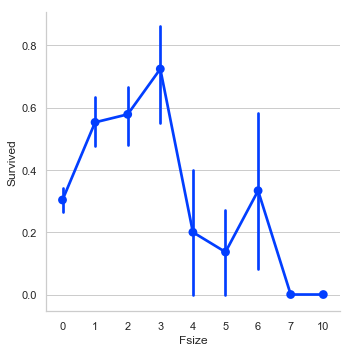

In [62]:
for df in [train_data,test_data,dataset]:
    df["Fsize"] = df["SibSp"] + df["Parch"]

  
survive_table(train_data,'Fsize')
g = sns.catplot(x="Fsize",y="Survived",data = train_data,kind='point')


Let's manualy onehot encode bin families as 'NoFamily'=0,'SFamily'<=3, 'GFamily'>3. Also we will drop the 'NoFamily', since it's data  will be redudant. 

In [63]:
for df in [train_data,test_data,dataset]:
    df['Fsize'] = df['Fsize'].map(lambda x: '0F' if x == 0 else('S' if 1<=x<=3 else 'G'))

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Survived,count,%of data
Fsize,,,
S,0.58,292,0.33
0F,0.30,537,0.60
G,0.16,62,0.07


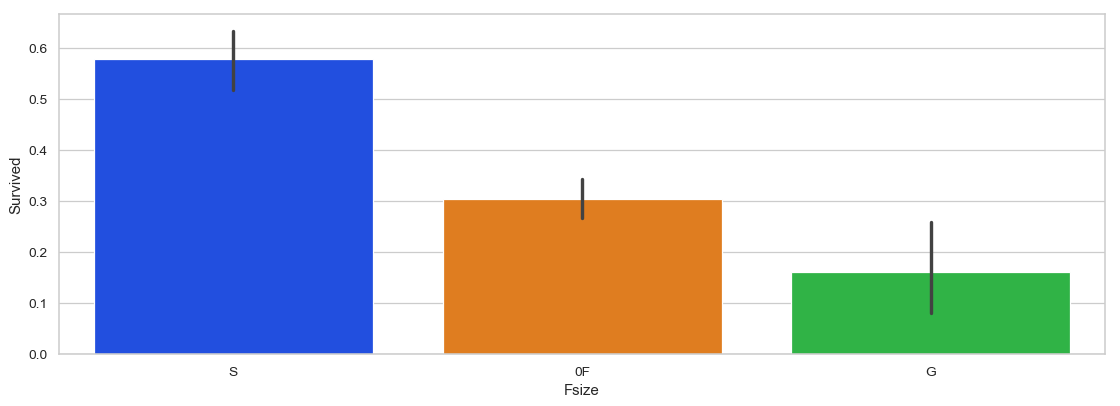

In [64]:
survive_table(train_data,'Fsize')
plt.figure(figsize=(15,5),dpi=90)
g = sns.barplot(x='Fsize',y='Survived', data = train_data)

Now we got three cleary distinc groups. 

In [65]:
# the modifications must be done to whole dataset, to avoid divergence in OHE size
dataset = pd.get_dummies(dataset,prefix_sep='_',drop_first=False,columns=['Fsize'])
# dataset = dataset.drop(columns=['Fsize_0F'])

train_data = dataset[:len(train_data.index)]
test_data = dataset[-len(test_data.index):]

# Feature: Ticket

Todo: We could check for extra data from ticket prefix in a similar way of what we did with title. It may represent something about who bought it.

In [66]:
print(sorted(train_data['Ticket'].unique()))

['110152', '110413', '110465', '110564', '110813', '111240', '111320', '111361', '111369', '111426', '111427', '111428', '112050', '112052', '112053', '112058', '112059', '112277', '112379', '113028', '113043', '113050', '113051', '113055', '113056', '113059', '113501', '113503', '113505', '113509', '113510', '113514', '113572', '113760', '113767', '113773', '113776', '113781', '113783', '113784', '113786', '113787', '113788', '113789', '113792', '113794', '113796', '113798', '113800', '113803', '113804', '113806', '113807', '11668', '11751', '11752', '11753', '11755', '11765', '11767', '11769', '11771', '11774', '11813', '11967', '12233', '12460', '12749', '13049', '13213', '13214', '13502', '13507', '13509', '13567', '13568', '14311', '14312', '14313', '14973', '1601', '16966', '16988', '17421', '17453', '17463', '17464', '17465', '17466', '17474', '17764', '19877', '19928', '19943', '19947', '19950', '19952', '19972', '19988', '19996', '2003', '211536', '21440', '218629', '219533', 

Sorted Ticket data reveals plain numbers, prefix with a space beteween numerical data. Some distinguishing patterns. And what ssems to be some 'misspelling': 'STON/O2' and 'STON/O 2'; 'WE/P' and 'W.E.P.'.
Let'see just the prefixs:

In [67]:
#First lets remove symbols:
for df in [train_data,test_data,dataset]:
    Prefix = []
    for i in list(df['Ticket']):
        if i.isdigit():
            cleaner_str = '0_NoPre'
        else:    
            cleaner_str = i.replace(".","").replace("/","")
            if cleaner_str.count(' ') > 1:
                cleaner_str = cleaner_str.replace(" ", '', 1)
            cleaner_str=cleaner_str.split(' ')[0]
        Prefix.append(cleaner_str) 
    df["Prefix"] = Prefix

# Let's see what remais on the training data:
print(sorted(train_data['Prefix'].unique()))

# Let's see it's survival data:
survive_table(train_data,'Prefix',sort = False)

['0_NoPre', 'A4', 'A5', 'AS', 'C', 'CA', 'CASOTON', 'FC', 'FCC', 'Fa', 'LINE', 'PC', 'PP', 'PPP', 'SC', 'SCA4', 'SCAH', 'SCAHBasle', 'SCOW', 'SCPARIS', 'SCParis', 'SOC', 'SOP', 'SOPP', 'SOTONO2', 'SOTONOQ', 'SP', 'STONO2', 'SWPP', 'WC', 'WEP']


C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,Survived,count,%of data
Prefix,,,
0_NoPre,0.38,661,0.74
A4,0.00,7,0.01
A5,0.10,21,0.02
AS,0.00,1,0.00
C,0.40,5,0.01
CA,0.34,41,0.05
CASOTON,0.00,1,0.00
FC,0.00,1,0.00
FCC,0.80,5,0.01


We find out a lot of small groups. This could lead to high overfitting. 
In order to prevent this, we could try to agroup them by some specific logic.

First, lets unite them acorrding to what seems to be equivalent groups:
- we could unite all "A*",also:
- All "C* ", all "F* ", all "P* ", all "SC* ", all "SO* " and "ST* "(misspelling?), and all W*

In [68]:
def convert_prefix(df):
    df_prefix_list = []
    for prefix in list(df['Prefix']):
        if prefix == '0_NoPre':
            prefix = prefix
        elif prefix[:2] == 'SC':
            prefix = 'SC'
        elif (prefix[:2] == 'SO') | (prefix[0:1] == 'ST'):
            prefix = 'SO'
        else :
            prefix = prefix[0]
        df_prefix_list.append(prefix) 
    df['Prefix'] = df_prefix_list
    return df


for df in [train_data,test_data,dataset]:
    df = convert_prefix(df)



C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


We use the train data to define a fix prefix list, so we dont get any data leakage. Also, we must prevent handle codes that may appear in test data and are not available in train data. This data will be compressed into more representative groups step by step as we analise it.

In [69]:
train_prefix_list = list(train_data['Prefix'])

#Let's update all data
for df in [train_data,test_data,dataset]:
    df['Prefix'] = [i if (i in train_prefix_list) else 'Rare' for i in df['Prefix']]

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [70]:
# Let's see what remais on the training data:
print(sorted(train_data['Prefix'].unique()))

# Let's see it's survival data:
survive_table(train_data,'Prefix',sort = False)

['0_NoPre', 'A', 'C', 'F', 'L', 'P', 'S', 'SC', 'SO', 'W']


,Survived,count,%of data
Prefix,,,
0_NoPre,0.38,661,0.74
A,0.07,29,0.03
C,0.34,47,0.05
F,0.57,7,0.01
L,0.25,4,0.00
P,0.65,65,0.07
S,0.48,21,0.02
SC,0.47,17,0.02
SO,0.11,27,0.03


In [71]:
# count and list all data that represents more than 1% of available data
prefix_top_count=train_data['Prefix'].value_counts()>len(train_data)/100 
prefix_top_list=prefix_top_count[prefix_top_count].index

#Let's update all data
for df in [train_data,test_data,dataset]:
    df['Prefix'] = [i if (i in prefix_top_list) else 'Rare' for i in df['Prefix']]


C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


['0_NoPre', 'A', 'C', 'P', 'Rare', 'S', 'SC', 'SO', 'W']


,Survived,count,%of data
Prefix,,,
0_NoPre,0.38,661,0.74
A,0.07,29,0.03
C,0.34,47,0.05
P,0.65,65,0.07
Rare,0.45,11,0.01
S,0.48,21,0.02
SC,0.47,17,0.02
SO,0.11,27,0.03
W,0.15,13,0.01


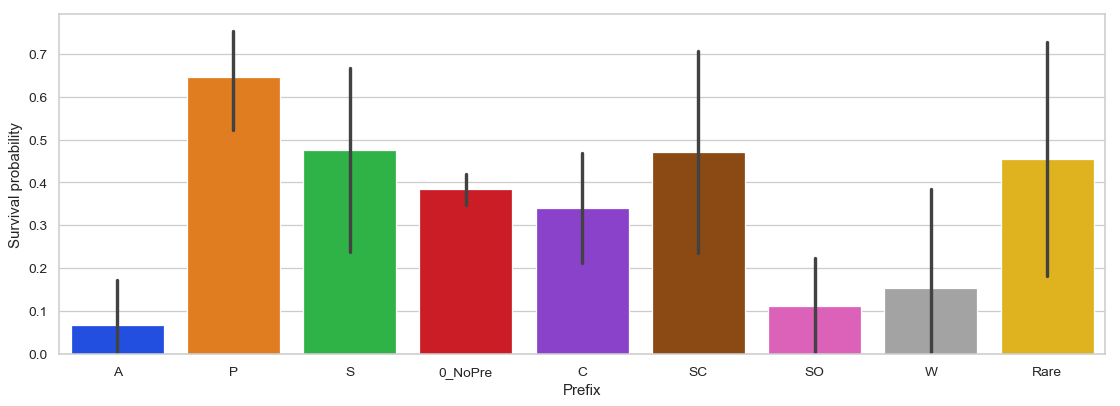

In [72]:
print(sorted(train_data['Prefix'].unique()))

survive_table(train_data,'Prefix',sort = False)

plt.figure(figsize=(15, 5), dpi= 90)
g = sns.barplot(x='Prefix',y='Survived', data = train_data)
g = g.set_ylabel('Survival probability')

We find out that we still have lots of groups, and that a lot of them are very small. Futhermore,  there is very similar mean&unceartanty groups that we may join in the same group. P is a very unique type.  We could group SO, W and A. We may group C and NoPre. Finnaly, we could group Rare, Sc, and S.   

As it will be seen in the next steps we will merge this final group to the "NoPre" group. In the meanwhile we will aproach data as a copy of original data for didatic purposes. 

In [73]:
temp_train_data = train_data.copy()
temp_Prefix_Dict = {'0_NoPre':'0_NoPre', 'A':'SO.A.W', 'C':'0_NoPre', 'P':'P', 'Rare':'Rare',
                'S':'Rare', 'SC':'Rare', 'SO':'SO.A.W', 'W':'SO.A.W'}

temp_train_data["Prefix"] = temp_train_data["Prefix"].replace(temp_Prefix_Dict)


,Survived,count,%of data
Prefix,,,
P,0.65,65,0.07
Rare,0.47,49,0.05
0_NoPre,0.38,708,0.79
SO.A.W,0.10,69,0.08


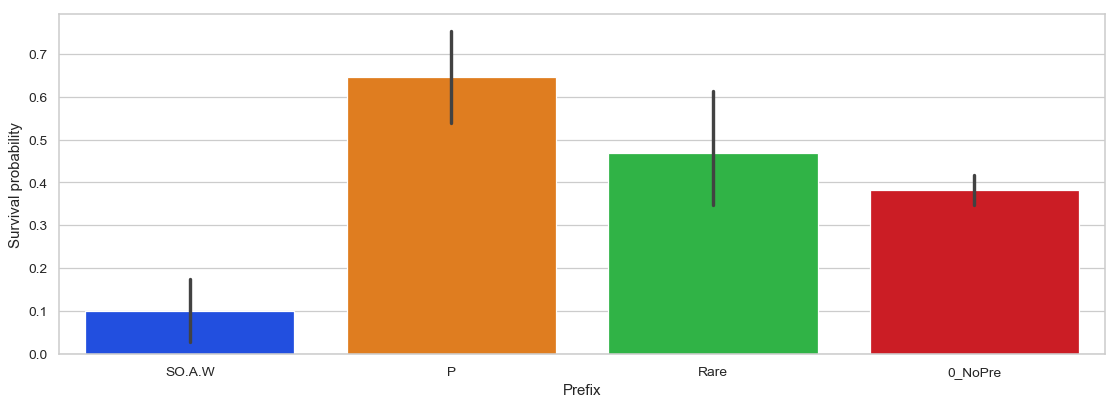

In [74]:
survive_table(temp_train_data,'Prefix',sort = 'Survived')
#Prefix  vs Survived
plt.figure(figsize=(15, 5), dpi= 90)
g = sns.barplot(x='Prefix',y='Survived', data = temp_train_data)
g = g.set_ylabel('Survival probability')

As it may be seen, Rare is not an stable group, ir is a intermediary between 0_NoPre and P. Also it's high unceartanty may put it's true value between any of the groups. We could merge Rare with either of the groups. Remember, merging is done here in other to avoid bias in the model. In order to reduce this bias we are merging groups to product less biased majorgroups. As we don't know the reason for some tickets having prefix and other don't, we may guess that the prefix of tickets witout prefix was lost. And that this lost data may have been the equivalents of the rare data. 

In this line of tought we will merge 0_NoPre and Rare. So our final dict will be applied to all data:

In [75]:
#Set the prefix list
Prefix_Dict = {'0_NoPre':'Rare/NoPre', 'A':'SO.A.W', 'C':'Rare/NoPre', 'P':'P', 'Rare':'Rare/NoPre',
                'S':'Rare/NoPre', 'SC':'Rare/NoPre', 'SO':'SO.A.W', 'W':'SO.A.W'}

#Let's update all data
for df in [train_data,test_data,dataset]:
    df["Prefix"] = df["Prefix"].replace(Prefix_Dict)


C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Survived,count,%of data
Prefix,,,
P,0.65,65,0.07
Rare/NoPre,0.39,757,0.85
SO.A.W,0.10,69,0.08


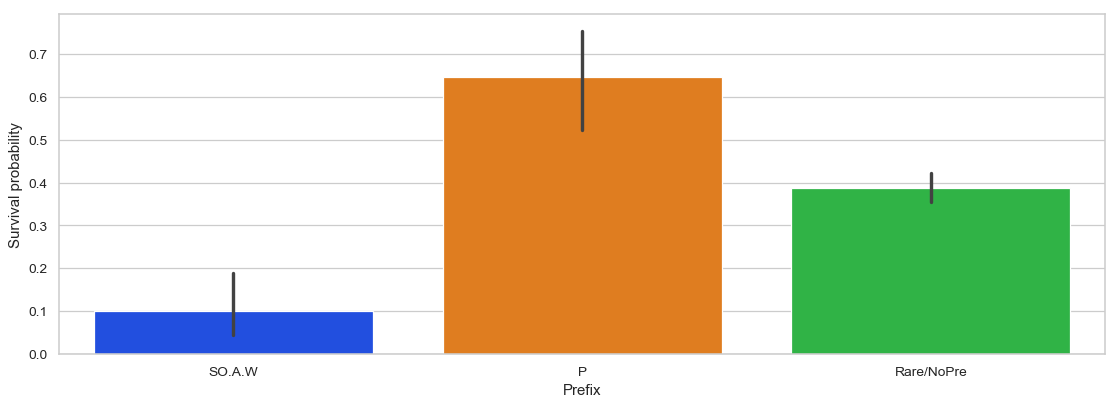

In [76]:
survive_table(train_data,'Prefix',sort = 'Survived')
#Prefix  vs Survived
plt.figure(figsize=(15, 5), dpi= 90)
g = sns.barplot(x='Prefix',y='Survived', data = train_data)
g = g.set_ylabel('Survival probability')

Now we got 3 quite distinguishable groups: Most of the data are Rare/NoPrefix data, and have a 39% survival chance. The SO.A.W Group represent lower chances of survival, and the P Group presents higher chances fo survival.  

In [77]:
dataset.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Female', 'AgeBin_0.0', 'AgeBin_1.0', 'AgeBin_2.0', 'AgeBin_3.0',
       'AgeBin_4.0', 'AgeBin_5.0', 'AgeBin_6.0', 'AgeBin_7.0', 'AgeBin_8.0',
       'AgeBin_9.0', 'Emb_C', 'Emb_Q', 'HaveCabin', 'Title_Master',
       'Title_Rev', 'Title_f_Rare', 'Title_m_Rare', 'Title_ordinary',
       'Fsize_0F', 'Fsize_G', 'Fsize_S', 'Prefix'],
      dtype='object')

In [78]:
# the modifications must be done to whole dataset, to avoid divergence in OHE size
dataset = pd.get_dummies(dataset,prefix_sep='_',drop_first=False,columns=['Prefix'])
# dataset = dataset.drop(columns=['Prefix_Rare/NoPre'])

train_data = dataset[:len(train_data.index)]
test_data = dataset[-len(test_data.index):]

In [79]:
#Let's drop the original data that we won't use anymore
for df in [train_data,test_data,dataset]:
    df.drop(columns=['Ticket'],inplace=True)

C:\Users\vitor\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


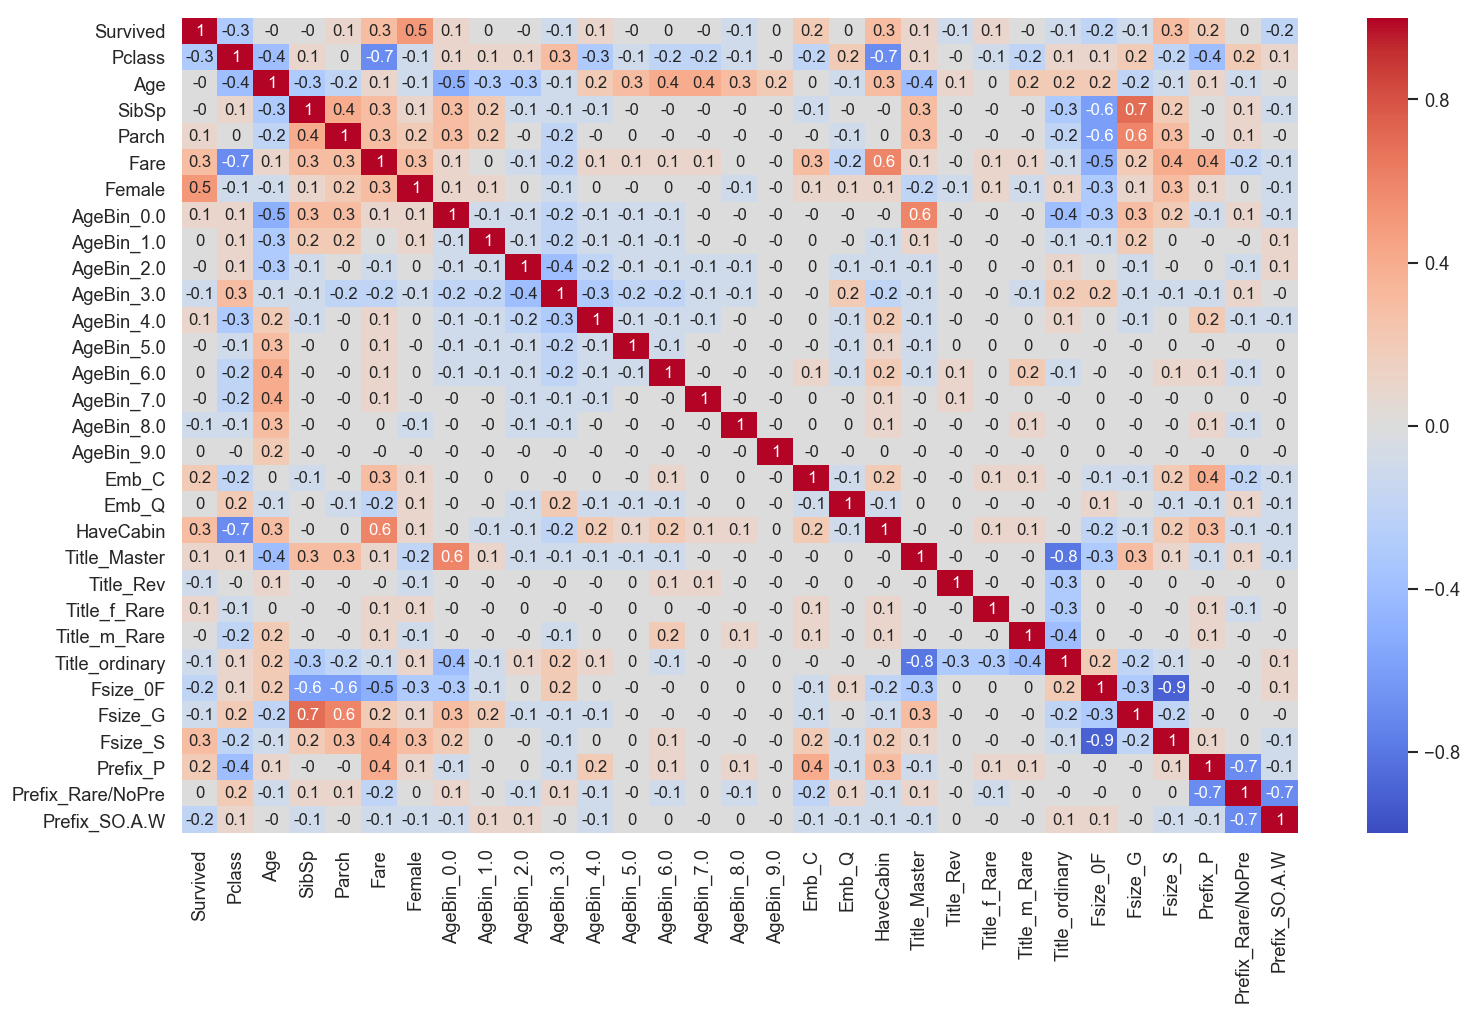

In [80]:
plt.figure(figsize=(15, 9), dpi= 120)
g = sns.heatmap(train_data.corr().round(1),
                annot=True, center=0, vmin=-1, vmax=1,
                cmap = "coolwarm")

Our final Correlation table, shows that we may have find more correlations than we had before. 

Before the Feature Engineering we had the major isfemale correlation. And only Pclass and Fare as the next highest Survival correlated features(0.3), and they were both higly dependent (0.7). Now we added Emb_C, HAveCabin, Fsize_S, Prefix_P and Prefix_SO.A.W as medium correlated (0.2-0.3) and maninly independent. Also we added Some small correlations (.1). 

Futhermore, there is the OH columns we droped for redundancy in data. They may be higly correlated and will add to the moddeling.

In [81]:
train_data = dataset[:len(train_data.index)]
test_data = dataset[-len(test_data.index):]

test_data.drop(columns=["Survived"],inplace=True)

# Modeling

In [82]:
from xgboost import XGBRegressor


In [83]:
Y_train = train_data["Survived"].astype(int)
X_train = train_data.drop(columns=['Survived'])

In [84]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [85]:
# Build to use classifiers list
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [86]:
# List CV results for used clasifiers
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=2))

# Transform CV results to mean and std 
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

# Build data into panda dataframe
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

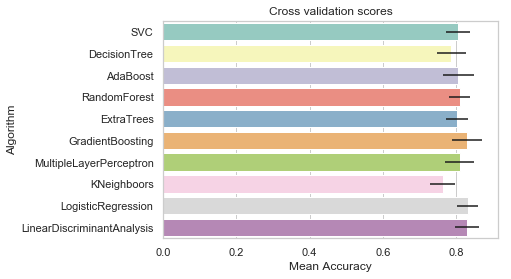

In [88]:
# Plot as hbars the mean and std
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [89]:
# DecisionTreeClassifier
DTC = DecisionTreeClassifier()

DTC_param_grid ={"criterion" : ["gini", "entropy"],
                 "splitter" :   ["best", "random"],
                 "max_leaf_nodes" :[5, 25, 50, 100, 250, 500,None],
                 'max_depth':[5,10,25,50,100,250,500,None]}

gsDTC = GridSearchCV(DTC,param_grid = DTC_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsDTC.fit(X_train,Y_train)

DTC_best = gsDTC.best_estimator_

gsDTC.best_score_

Fitting 10 folds for each of 224 candidates, totalling 2240 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 1344 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done 2240 out of 2240 | elapsed:    9.3s finished
C:\Users\vitor\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8372615039281706

In [90]:
# Linear Discriminant Analysis
LDA = LinearDiscriminantAnalysis()

LDA_param_grid ={'solver' : ['svd','lsqr']}

gsLDA = GridSearchCV(LDA,param_grid = LDA_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsLDA.fit(X_train,Y_train)

LDA_best = gsLDA.best_estimator_

gsLDA.best_score_

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
C:\Users\vitor\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.8294051627384961

In [91]:
# Logistic Regression
logistR = LogisticRegression()

logistR_param_grid ={'penalty' : ['l1', 'l2'],
                'C' : np.logspace(-4, 4, 20),
                'solver' : ['liblinear']}

gslogistR = GridSearchCV(logistR,param_grid = logistR_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gslogistR.fit(X_train,Y_train)

logistR_best = gslogistR.best_estimator_

gslogistR.best_score_

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    2.6s finished
C:\Users\vitor\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8338945005611672

In [92]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=2)]: Done 760 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done 1120 out of 1120 | elapsed:    6.8s finished


0.8215488215488216

In [93]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   28.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 540 out of 540 | elapsed:  1.7min finished
C:\Users\vitor\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8305274971941639

In [94]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   38.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 540 out of 540 | elapsed:  2.0min finished
C:\Users\vitor\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8372615039281706

In [95]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done 172 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   44.7s finished
C:\Users\vitor\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8372615039281706

In [96]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   24.5s
[Parallel(n_jobs=2)]: Done 280 out of 280 | elapsed:   44.1s finished


0.8305274971941639

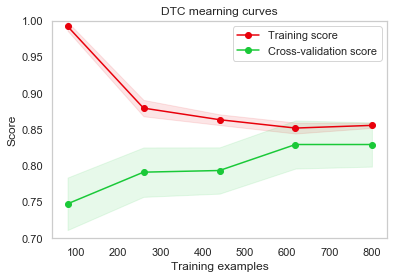

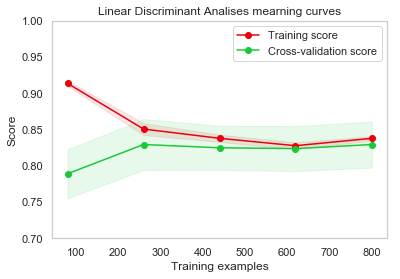

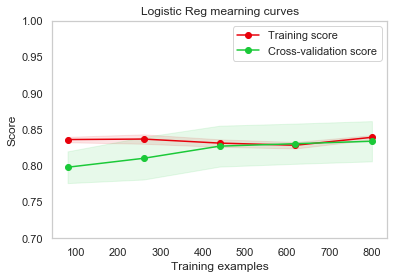

In [97]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=2, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    axes = plt.gca()
    axes.set_ylim([0.7,1.0])
    return plt
g = plot_learning_curve(gsDTC.best_estimator_,"DTC mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsLDA.best_estimator_,"Linear Discriminant Analises mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gslogistR.best_estimator_,"Logistic Reg mearning curves",X_train,Y_train,cv=kfold)


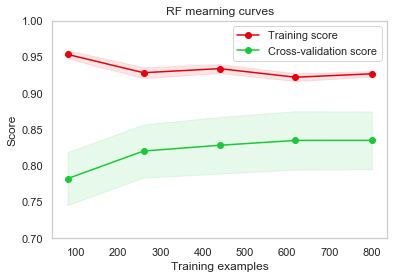

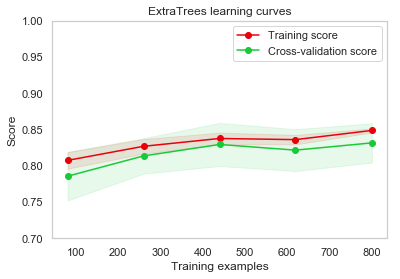

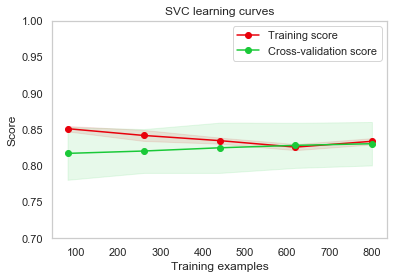

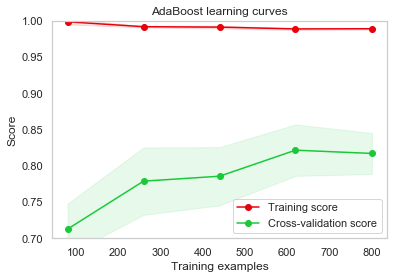

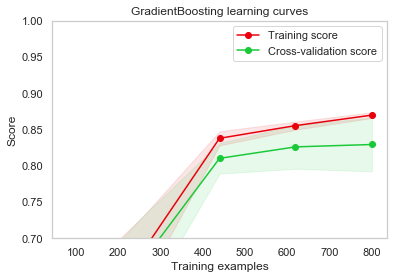

In [98]:

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

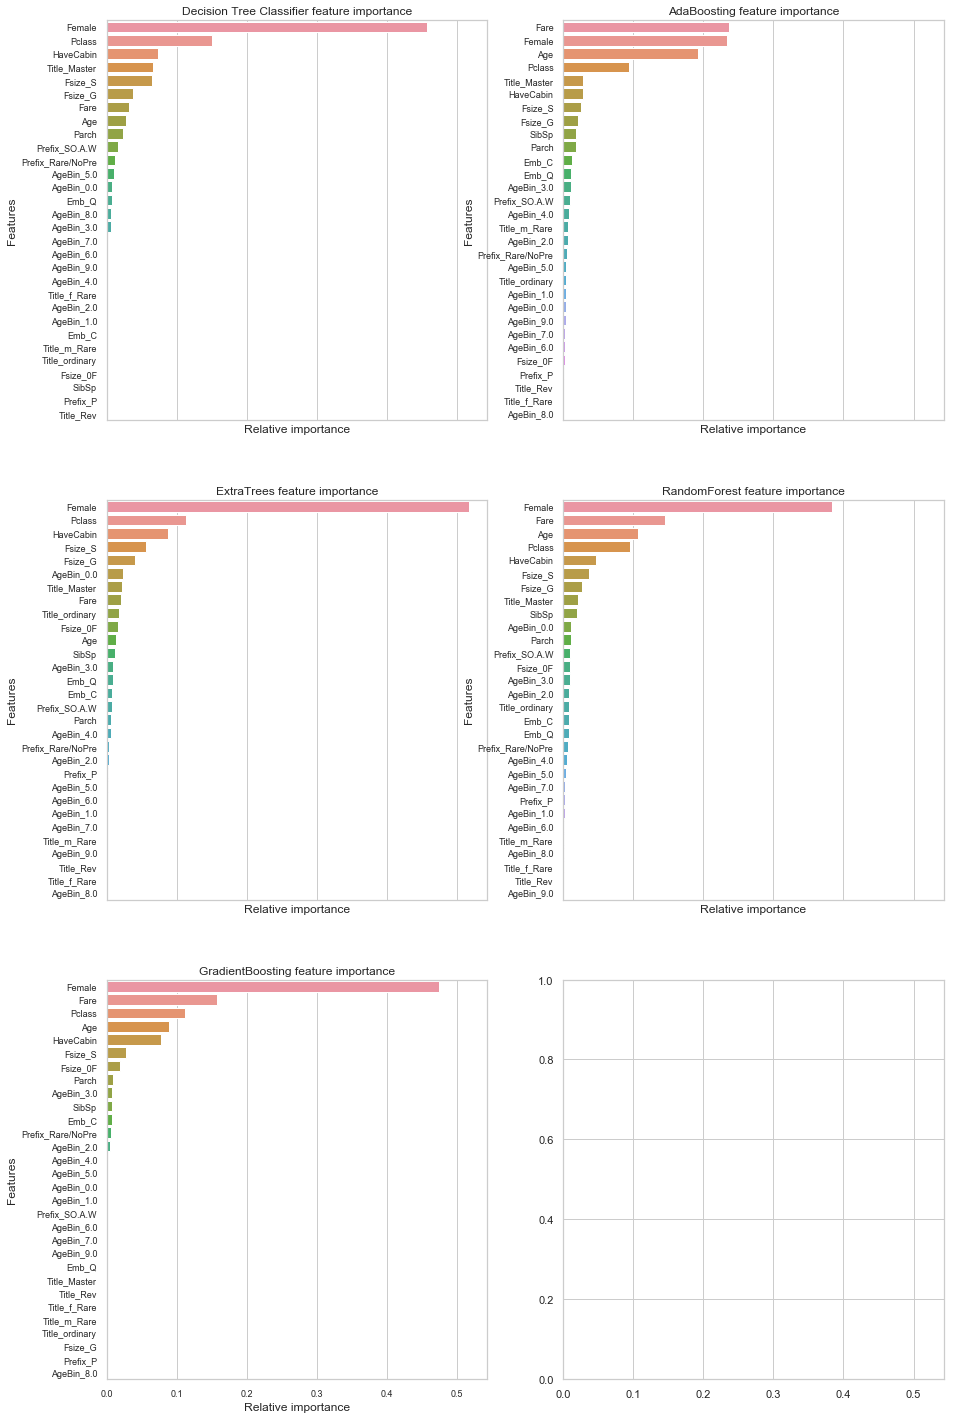

In [99]:
ncols = 2
nrows = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,25))

names_classifiers = [("Decision Tree Classifier", DTC_best),("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        if (row == nrows-1) & (col == ncols-1): break #odd charts for pair grid
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

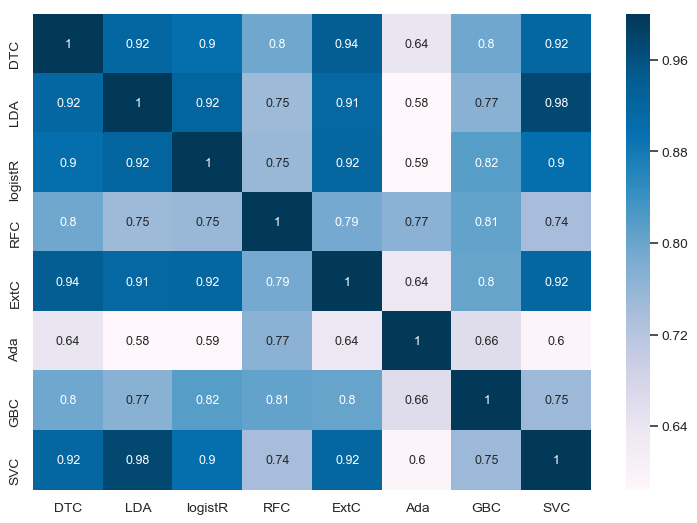

In [100]:
test_Survived_DTC = pd.Series(DTC_best.predict(test_data), name='DTC')
test_Survived_LDA = pd.Series(LDA_best.predict(test_data), name='LDA')
test_Survived_logistR = pd.Series(logistR_best.predict(test_data), name='logistR')

test_Survived_RFC = pd.Series(RFC_best.predict(test_data), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test_data), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test_data), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test_data), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test_data), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_DTC,test_Survived_LDA,test_Survived_logistR,
                              test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

plt.figure(figsize=(10,7),dpi=90)
g= sns.heatmap(ensemble_results.corr(),annot=True,cmap = "PuBu")

In [101]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=2)

votingC = votingC.fit(X_train, Y_train)

In [102]:
test_Survived = pd.Series(votingC.predict(test_data), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)
results.columns =['PassengerId','Survived']
results.to_csv("ensemble_python_base1.csv",index=False)


In [103]:
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [104]:
import dill
dill.dump_session('Base_Titanic_env.db')